# General Task
 
### Common Test I. Multi-Class Classification

- Task: Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

- Dataset Description: The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.
Evaluation Metrics: ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

## Downloading the data

In [2]:
# import os
# import gdown
# import zipfile

# # Define the Google Drive file ID and output filename
# file_id = "1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ"
# output_file = "dataset.zip"

# # Download the file using gdown
# gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", output_file, quiet=False)

# # Create a directory for extraction
# extract_dir = "dataset"
# os.makedirs(extract_dir, exist_ok=True)

# # Unzip the file
# try:
#     with zipfile.ZipFile(output_file, 'r') as zip_ref:
#         zip_ref.extractall(extract_dir)
#     print("Extraction successful!")
# except zipfile.BadZipFile:
#     print("Error: The downloaded file is not a valid ZIP file.")

# # List extracted files
# extracted_files = os.listdir(extract_dir)
# print("Extracted files:", extracted_files)


### My Approach

1. **Dataset Visualization**  
   Begin by visualizing the dataset to understand its structure, distribution, and any underlying patterns. This initial step is crucial for identifying anomalies and guiding subsequent analysis.

2. **Baseline Analysis with ResNet-18**  
   - **Objective:** Establish a performance baseline for the task.  
   - **Method:** Train a model using a ResNet-18 backbone, inspired by prior work that demonstrated its effectiveness on lensing data.  
   - **Rationale:**  
     - ResNet-18 has consistently achieved top performance in previous studies on gravitational lensing datasets.  
     - CNNs are known to outperform alternative classification methods in this domain. However, caution is warranted as models trained solely on simulated data may not generalize well to real-world scenarios.

3. **Evaluating the Impact of Non-Physics-Informed Augmentations**  
   - **Goal:** Determine if applying generic augmentations (not informed by the underlying physics) degrades model quality.  
   - **Purpose:** This experiment helps underscore the importance of simulation fidelity and the need for domain-specific augmentations.

4. **Interpretability via Grad-CAM Experiments**  
   - **Objective:** Use Grad-CAM to probe the decision-making process of the trained model.  
   - **Focus:**  
     - Identify any instances where the model might be “cheating” by relying on spurious cues (e.g., noise in simulated backgrounds) instead of genuine signal features.  
     - Understand these behaviors to inform improvements and ensure that the model’s interpretations are robust and reliable in real-world applications.

5. **Future Directions: Physics-Informed Augmentations**  
   - **Next Steps:**  
     - Develop and integrate physics-informed augmentation techniques aimed at mitigating the model's tendency to cheat by exploiting simulation-specific noise.  
     - Enhance the model's generalization capabilities by aligning the augmentation process more closely with real-world physics, thereby improving its applicability.

This structured methodology not only provides a robust baseline using a familiar architecture like ResNet-18 but also addresses critical challenges such as the generalization gap between simulated and real data. It further emphasizes the importance of model interpretability, paving the way for more resilient and trustworthy applications.


### Training the baseline Res-Net model

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import os
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt


### Visualization of the dataset

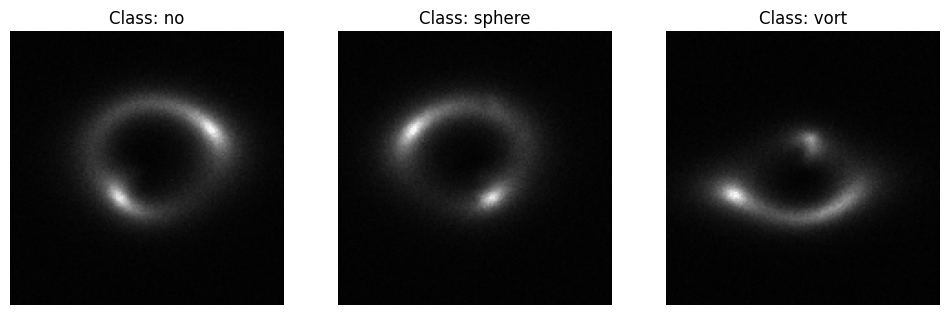

In [ ]:

# Define dataset paths
train_dir = "dataset/dataset/train"

# Class names (folders)
class_names = ["no", "sphere", "vort"]

# Function to load a sample image from each class
def load_sample_images(base_dir, class_names):
    sample_images = {}
    
    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        files = os.listdir(class_path)
        
        # Load the first available .npy file in the class folder
        for file in files:
            if file.endswith(".npy"):
                file_path = os.path.join(class_path, file)
                image = np.load(file_path)
                
                # Ensure the image is 2D (remove extra dimension)
                if image.shape[0] == 1:  # Shape (1, H, W) -> (H, W)
                    image = image.squeeze(0)
                
                sample_images[class_name] = image
                break  # Take only one sample per class

    return sample_images

# Load images
sample_images = load_sample_images(train_dir, class_names)

# Function to plot images
def plot_images(images_dict):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for i, (label, image) in enumerate(images_dict.items()):
        ax = axes[i]
        ax.imshow(image, cmap="gray")  # Assuming grayscale images
        ax.set_title(f"Class: {label}")
        ax.axis("off")

    plt.show()

# Display the images
plot_images(sample_images)


In [ ]:

class NPZDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = [cls for cls in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, cls))]  # Filter only directories
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # Collect all file paths
        self.samples = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                if file.endswith(".npy"):
                    self.samples.append((os.path.join(class_path, file), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        image = np.load(file_path) 

        # Ensure the image is 2D (grayscale) and reshape
        if image.shape[0] == 1:
            image = image.squeeze(0)  # Remove extra dimension
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dim back for PyTorch

        return image, label


In [7]:
# Dataset Paths
train_dir = "dataset/dataset/train"
val_dir = "dataset/dataset/val"

# Create dataset objects
train_dataset = NPZDataset(train_dir)
val_dataset = NPZDataset(val_dir)

# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check dataset size
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Training samples: 30000, Validation samples: 7500


In [8]:
# Load pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Modify first layer to accept grayscale images (1 input channel instead of 3)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify last layer for 3 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Define loss function (CrossEntropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:

def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Store predictions and labels
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_preds.append(probs)
            all_labels.append(labels.cpu().numpy())

    # Compute ROC-AUC
    all_preds = np.vstack(all_preds)
    all_labels = np.hstack(all_labels)
    auc_score = roc_auc_score(all_labels, all_preds, multi_class='ovr')

    return val_loss / len(val_loader), auc_score


In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate after each epoch
        val_loss, val_auc = evaluate_model(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

    print("Training Complete!")


In [12]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1/10, Train Loss: 1.1234, Val Loss: 1.0984, Val AUC: 0.5320
Epoch 2/10, Train Loss: 1.0442, Val Loss: 1.3591, Val AUC: 0.7054
Epoch 3/10, Train Loss: 0.7823, Val Loss: 0.6066, Val AUC: 0.8967
Epoch 4/10, Train Loss: 0.5158, Val Loss: 0.5128, Val AUC: 0.9419
Epoch 5/10, Train Loss: 0.3635, Val Loss: 0.3362, Val AUC: 0.9668
Epoch 6/10, Train Loss: 0.2989, Val Loss: 0.3748, Val AUC: 0.9714
Epoch 7/10, Train Loss: 0.2521, Val Loss: 0.3171, Val AUC: 0.9773
Epoch 8/10, Train Loss: 0.2176, Val Loss: 0.3260, Val AUC: 0.9766
Epoch 9/10, Train Loss: 0.1867, Val Loss: 0.2388, Val AUC: 0.9824
Epoch 10/10, Train Loss: 0.1611, Val Loss: 0.2752, Val AUC: 0.9820
Training Complete!


In [13]:
# Save the trained model
torch.save(model.state_dict(), "deeplense_model.pth")

# Load for inference
model.load_state_dict(torch.load("deeplense_model.pth"))
model.eval()


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

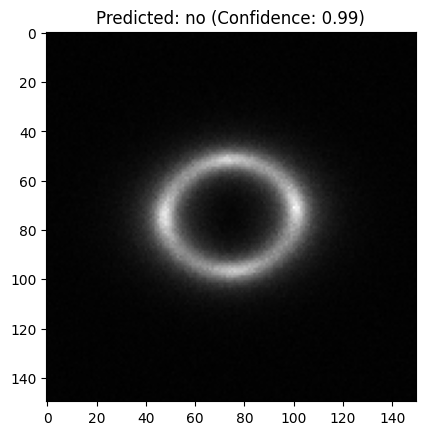

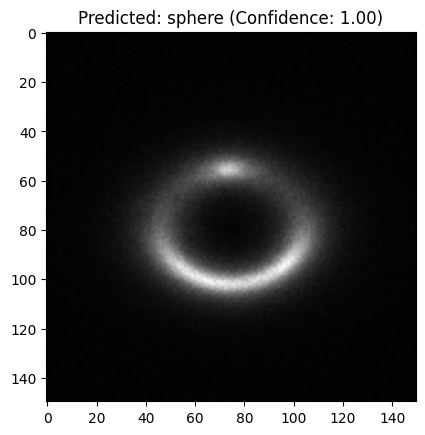

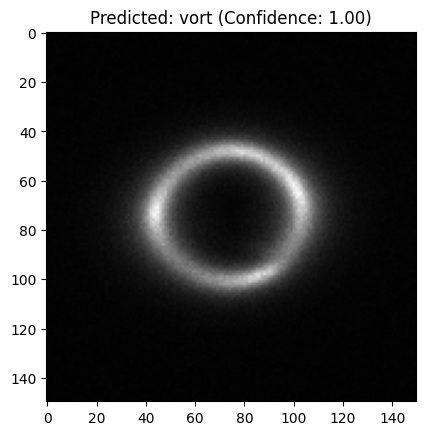

In [ ]:
from PIL import Image

def predict_image(file_path, model):
    model.eval()

    # Load image
    image = np.load(file_path)
    
    # Ensure correct shape (H, W) -> (1, H, W)
    if image.shape[0] == 1:
        image = image.squeeze(0)
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.softmax(output, dim=1).cpu().numpy()
        predicted_class = np.argmax(probs)

    # Display
    plt.imshow(image, cmap="gray")
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {probs[0][predicted_class]:.2f})")
    plt.show()

# Example Usage
predict_image("dataset/dataset/val/no/1.npy", model)
predict_image("dataset/dataset/val/sphere/1.npy", model)
predict_image("dataset/dataset/val/vort/1.npy", model)


In [ ]:

def evaluate_model_for_eval(model, data_loader, criterion):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Store predictions and labels
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_preds.append(probs)
            all_labels.append(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.vstack(all_preds)
    all_labels = np.hstack(all_labels)

    # Compute AUC Score
    auc_score = roc_auc_score(all_labels, all_preds, multi_class='ovr')

    return val_loss / len(data_loader), auc_score, all_labels, all_preds


In [ ]:

def plot_roc_curves(y_true, y_scores, dataset_type="Validation"):
    n_classes = y_scores.shape[1]
    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for {dataset_type} Dataset")
    plt.legend(loc="lower right")
    plt.show()


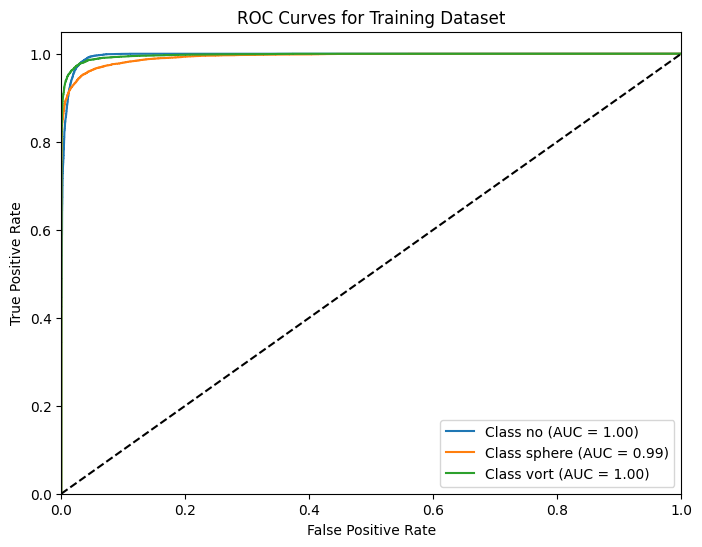

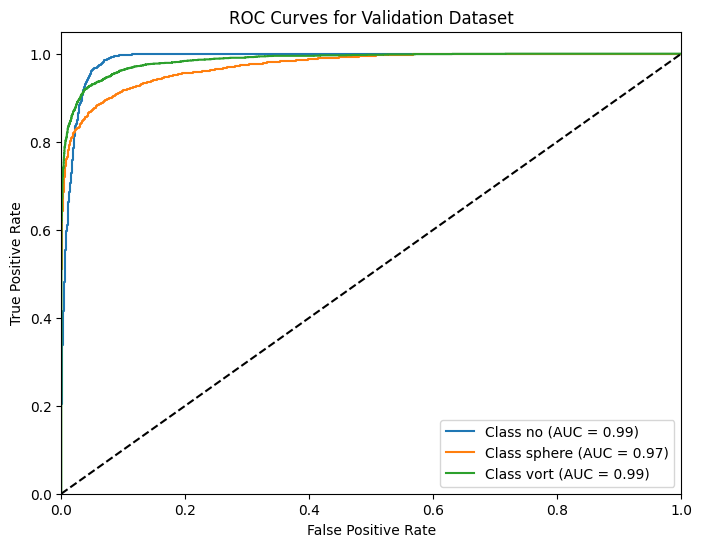

In [19]:
# Evaluate on training and validation sets
train_loss, train_auc, train_labels, train_preds = evaluate_model_for_eval(model, train_loader, criterion)
val_loss, val_auc, val_labels, val_preds = evaluate_model_for_eval(model, val_loader, criterion)

# Plot ROC curves
plot_roc_curves(train_labels, train_preds, dataset_type="Training")
plot_roc_curves(val_labels, val_preds, dataset_type="Validation")


# Trying augmentations to quench my personal curiosity!

After reading some material online, I found out that, strong lensing substructures are anisotropic (direction sensitive), therefore applying rotations and random rescaling should make vortices and subhalo features unrecognizable. To test this hypothesis, I apply the below augmentations, and to check whether doing so while improving model complexity [adding a few extra layers after resnet18] deteoriates the performance. [Spoiler - It actually does !]

In [24]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(3, 3)),
    transforms.ToTensor(),
])


In [28]:
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

class NPZDataset_aug(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = [cls for cls in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, cls))]
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # Collect all file paths
        self.samples = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                if file.endswith(".npy"):
                    self.samples.append((os.path.join(class_path, file), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        image = np.load(file_path)  # Load .npy file

        # Ensure correct shape (1, H, W) and convert to tensor
        if image.shape[0] == 1:
            image = image.squeeze(0)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Convert to tensor (1, H, W)

        # Convert to PIL image before applying torchvision transforms
        if self.transform:
            image = to_pil_image(image)  # Convert tensor to PIL image
            image = self.transform(image)  # Apply transformations

        return image, label


In [ ]:
# Apply data augmentation for training only
train_dataset = NPZDataset_aug(train_dir, transform=train_transforms)  
val_dataset = NPZDataset_aug(val_dir, transform=transforms.Compose([transforms.ToTensor()]))  # No augmentation for val

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check dataset size
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Training samples: 30000, Validation samples: 7500


In [ ]:
# No need to Reinitialize the model

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1/10, Train Loss: 1.1191, Val Loss: 1.1066, Val AUC: 0.5025
Epoch 2/10, Train Loss: 1.1114, Val Loss: 1.1501, Val AUC: 0.5053
Epoch 3/10, Train Loss: 1.1089, Val Loss: 1.1205, Val AUC: 0.5019
Epoch 4/10, Train Loss: 1.1116, Val Loss: 1.0989, Val AUC: 0.4929
Epoch 5/10, Train Loss: 1.1068, Val Loss: 1.0994, Val AUC: 0.5020
Epoch 6/10, Train Loss: 1.1039, Val Loss: 1.1012, Val AUC: 0.4929
Epoch 7/10, Train Loss: 1.1031, Val Loss: 1.0987, Val AUC: 0.5074
Epoch 8/10, Train Loss: 1.1015, Val Loss: 1.1002, Val AUC: 0.5011
Epoch 9/10, Train Loss: 1.1018, Val Loss: 1.0988, Val AUC: 0.5052
Epoch 10/10, Train Loss: 1.1001, Val Loss: 1.0988, Val AUC: 0.5027
Training Complete!


In [ ]:

def evaluate_model_aug(model, data_loader, criterion):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Store predictions and labels
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_preds.append(probs)
            all_labels.append(labels.cpu().numpy())

    # Convert lists to numpy arrays
    if all_preds and all_labels:  # Ensure there's data before stacking
        all_preds = np.vstack(all_preds)
        all_labels = np.hstack(all_labels)

        # Compute AUC Score
        auc_score = roc_auc_score(all_labels, all_preds, multi_class='ovr')
    else:
        auc_score = 0.0  # If no data, return 0 AUC

    return val_loss / len(data_loader), auc_score, all_labels, all_preds


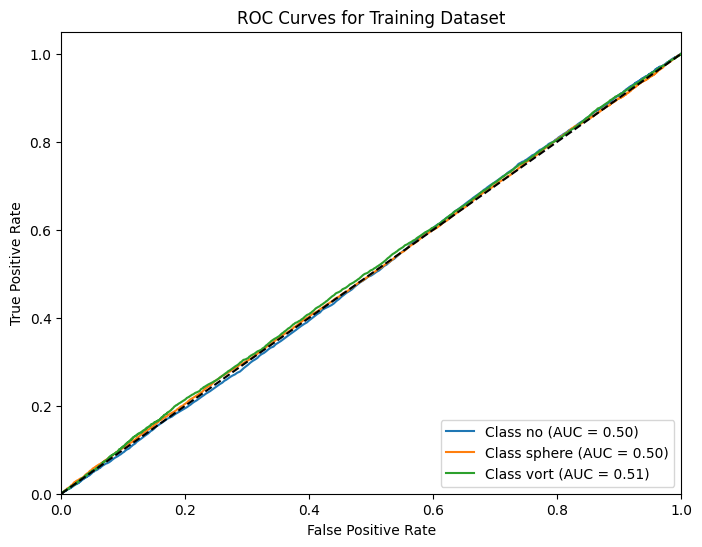

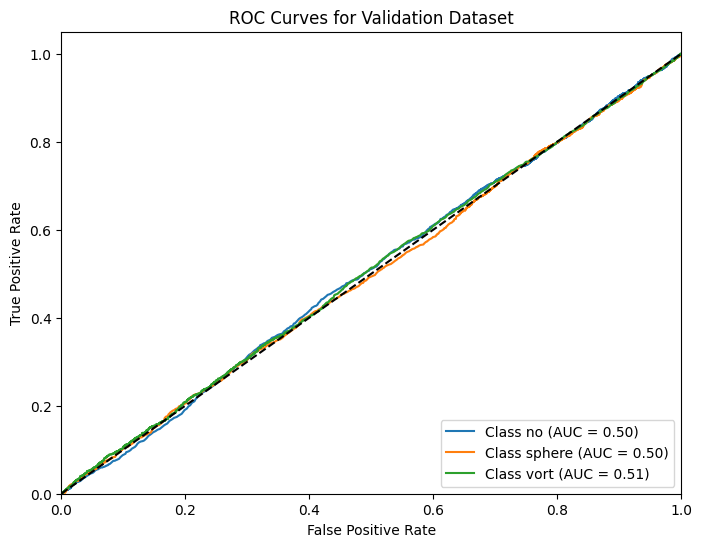

In [33]:
# Evaluate on training and validation sets
train_loss, train_auc, train_labels, train_preds = evaluate_model_aug(model, train_loader, criterion)
val_loss, val_auc, val_labels, val_preds = evaluate_model_aug(model, val_loader, criterion)

# Plot ROC curves
plot_roc_curves(train_labels, train_preds, dataset_type="Training")
plot_roc_curves(val_labels, val_preds, dataset_type="Validation")


So, it pretty clear that, whatever augmentation we apply in the future should be physics informed. We dont actually need to do that in this very task, as the data given to us itself is perfect [which rarely happens], and ResNet-18 performs pretty good on the task.

In [ ]:
# If you are running this in one run, it is suggested that, you clear the cache and model before processing, as I reinitialize the model again below for inference'

In [ ]:
import cv2
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


In [4]:
from torchvision import models
# Reload the correct model architecture
model = models.resnet18(pretrained=False)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)

# Load state dict properly
state_dict = torch.load("deeplense_model.pth", map_location=device)
if isinstance(state_dict, dict) and "model" in state_dict:
    state_dict = state_dict["model"]  # If saved inside another dict, extract it

model.load_state_dict(state_dict, strict=False)  # Allow missing keys
model = model.to(device)
model.eval()  # Put model in evaluation mode


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

target_layer = model.layer4[-1]  # Last conv layer of ResNet18
cam = GradCAM(model=model, target_layers=[target_layer])


In [6]:
import os

# Get a random validation image
val_dir = "dataset/dataset/val"
class_names = ["no", "sphere", "vort"]

def get_sample_image(class_label="no"):
    class_path = os.path.join(val_dir, class_label)
    sample_file = [f for f in os.listdir(class_path) if f.endswith(".npy")][0]
    return os.path.join(class_path, sample_file)

sample_sphere = get_sample_image("sphere")
sample_no = get_sample_image("no")
sample_vort = get_sample_image("vort")

In [ ]:
from pytorch_grad_cam.utils.image import show_cam_on_image

# Function to load and preprocess an image
def load_preprocess_image(image_path):
    image = np.load(image_path)

    # Ensure correct shape (H, W) if (1, H, W) format
    if image.shape[0] == 1:
        image = image.squeeze(0)  # Convert (1, H, W) → (H, W)

    # Normalize image for visualization
    image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))  # Min-max normalization

    # Convert to PyTorch tensor for model input
    input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)

    return image, image_normalized, input_tensor

# Load images
image_sphere, norm_sphere, tensor_sphere = load_preprocess_image(sample_sphere)
image_no, norm_no, tensor_no = load_preprocess_image(sample_no)
image_vort, norm_vort, tensor_vort = load_preprocess_image(sample_vort)


In [10]:
def generate_gradcam(input_tensor, image_normalized, target_class_idx):
    targets = [ClassifierOutputTarget(target_class_idx)]
    grayscale_cam = cam(input_tensor, targets)[0]  # Extract Grad-CAM heatmap
    
    # Convert grayscale image to 3-channel (RGB) for compatibility with show_cam_on_image
    image_rgb = np.stack([image_normalized] * 3, axis=-1)  # Convert (H, W) -> (H, W, 3)
    
    # Overlay heatmap on original image
    heatmap = show_cam_on_image(image_rgb, grayscale_cam, use_rgb=True)
    
    return heatmap


# Generate Grad-CAM heatmaps
heatmap_sphere = generate_gradcam(tensor_sphere, norm_sphere, target_class_idx=1)  # Sphere class
heatmap_no = generate_gradcam(tensor_no, norm_no, target_class_idx=0)  # No Substructure class
heatmap_vort = generate_gradcam(tensor_vort, norm_vort, target_class_idx=2)  # Vortex class


## Model Interpretability
- We see that the model, for no substructure class, sphere substructure class, is not paying attention at the ring structure, but looking at the background noise, which came from the simulation.
- This suggests that the model even after showing good results on the above given dataset, can fail on real world data tasks.

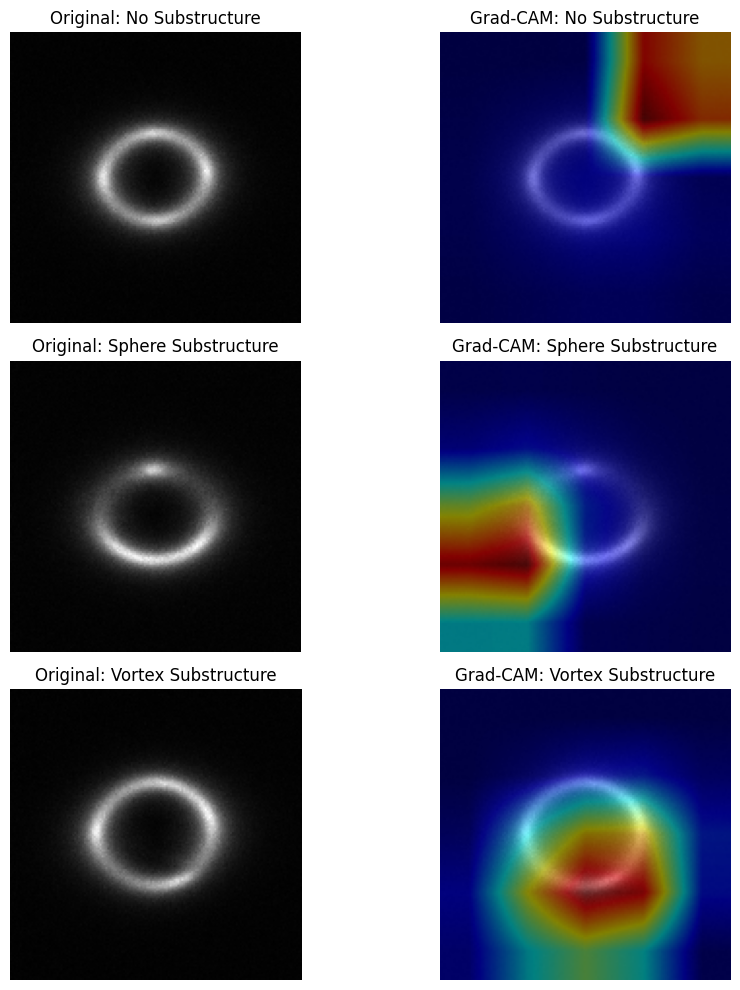

In [11]:
# Display all results
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Plot "No Substructure" Class
axes[0, 0].imshow(image_no, cmap="gray")
axes[0, 0].set_title("Original: No Substructure")
axes[0, 0].axis("off")

axes[0, 1].imshow(heatmap_no)
axes[0, 1].set_title("Grad-CAM: No Substructure")
axes[0, 1].axis("off")

# Plot "Sphere" Class
axes[1, 0].imshow(image_sphere, cmap="gray")
axes[1, 0].set_title("Original: Sphere Substructure")
axes[1, 0].axis("off")

axes[1, 1].imshow(heatmap_sphere)
axes[1, 1].set_title("Grad-CAM: Sphere Substructure")
axes[1, 1].axis("off")

# Plot "Vortex" Class
axes[2, 0].imshow(image_vort, cmap="gray")
axes[2, 0].set_title("Original: Vortex Substructure")
axes[2, 0].axis("off")

axes[2, 1].imshow(heatmap_vort)
axes[2, 1].set_title("Grad-CAM: Vortex Substructure")
axes[2, 1].axis("off")

plt.tight_layout()
plt.show()
